
# Multi-Layer Perceptron

In this notebook, we will train an MLP to classify images from the [MNIST](http://yann.lecun.com/exdb/mnist/) database hand-written digit database.

The process will be broken down into the following steps:

* Load and visualize the data
* Define a neural network
* Train the model
* Evaluate the performance of our trained model on a test dataset!

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

### Download datasets

In [2]:
num_workers = 0
batch_size = 20

# Transform the data to a tensor
transform = transforms.ToTensor()

# data locations
data_dir = '/Users/philsamoei/projects/ML/udacity/scholarshipchallenge/my-notes/data'

# Download training data
train_data = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)

# Download test data
test_data = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

Processing...
Done!


### Create mechanism for extracting 20% validation data from train data

In [25]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### Prepare data loaders

In [26]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize a Batch of Training Data

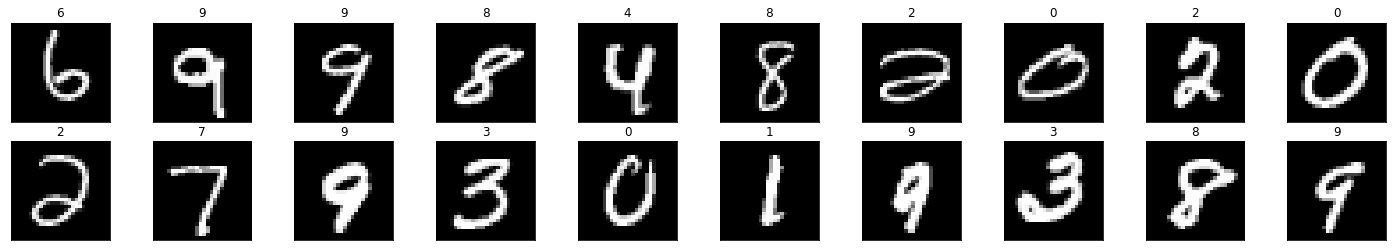

In [31]:
# Extract 1 batch of training images
images, labels = next(iter(train_loader))
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

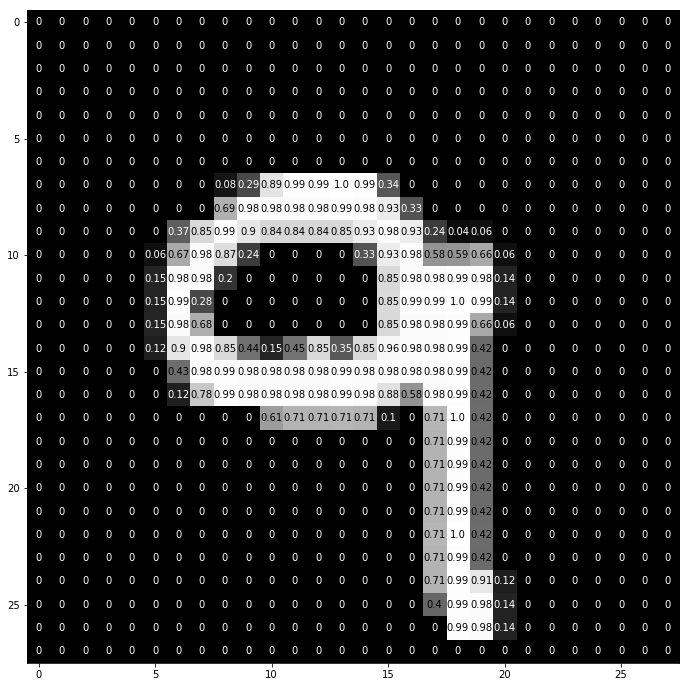

In [32]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### Neural Network Architecture 

In [36]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        hidden_3 = 512
        self.fc1 = nn.Linear(784, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.view(-1, 784)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
model = NeuralNet()
model

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

### Loss & Optimizer Functions

In [38]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Train the Network

In [41]:
n_epochs = 50

valid_loss_min = np.Inf

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/(len(train_loader))
    valid_loss = valid_loss/(len(valid_loader))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        print("Validation loss decreased ({:.6f} ----> {:.6f}). Saving model...".format(
        valid_loss_min, valid_loss
        ))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 26.494150 	Validation Loss: 8.631795
Validation loss decreased (inf ----> 8.631795). Saving model...
Epoch: 2 	Training Loss: 7.948994 	Validation Loss: 6.009369
Validation loss decreased (8.631795 ----> 6.009369). Saving model...
Epoch: 3 	Training Loss: 5.721361 	Validation Loss: 4.617497
Validation loss decreased (6.009369 ----> 4.617497). Saving model...
Epoch: 4 	Training Loss: 4.372263 	Validation Loss: 3.645105
Validation loss decreased (4.617497 ----> 3.645105). Saving model...
Epoch: 5 	Training Loss: 3.534402 	Validation Loss: 3.157032
Validation loss decreased (3.645105 ----> 3.157032). Saving model...
Epoch: 6 	Training Loss: 2.964919 	Validation Loss: 2.728079
Validation loss decreased (3.157032 ----> 2.728079). Saving model...
Epoch: 7 	Training Loss: 2.583743 	Validation Loss: 2.480139
Validation loss decreased (2.728079 ----> 2.480139). Saving model...
Epoch: 8 	Training Loss: 2.248908 	Validation Loss: 2.281354
Validation loss decreased (2.4801

### Load the Model with the Lowest Validation Loss

In [43]:
model.load_state_dict(torch.load('model.pt'))

### Test the Trained Network

In [44]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()


for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss = loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.000049

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 97% (1011/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 97% (961/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 97% (938/958)
Test Accuracy of     7: 97% (1002/1028)
Test Accuracy of     8: 97% (951/974)
Test Accuracy of     9: 98% (990/1009)

Test Accuracy (Overall): 98% (9818/10000)


In [52]:
torch.max(output, 1)

(tensor([16.7708, 16.2936, 11.5827, 12.9408, 14.5870, 13.1717, 15.0098, 10.6959,
          8.8206, 15.6315, 17.1378, 13.5973, 16.2245, 16.3033, 15.9308, 13.8557,
         15.2260, 18.1509, 10.5716, 16.1156], grad_fn=<MaxBackward0>),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]))

In [53]:
pred

tensor([2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [54]:
target

tensor([2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [55]:
correct

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=torch.uint8)

In [58]:
correct[3].item()

1

In [56]:
pred.eq(target.data.view_as(pred))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=torch.uint8)

### Visualize Sample Test Results

The text will be green for accurately classified examples and red for incorrect predictions.

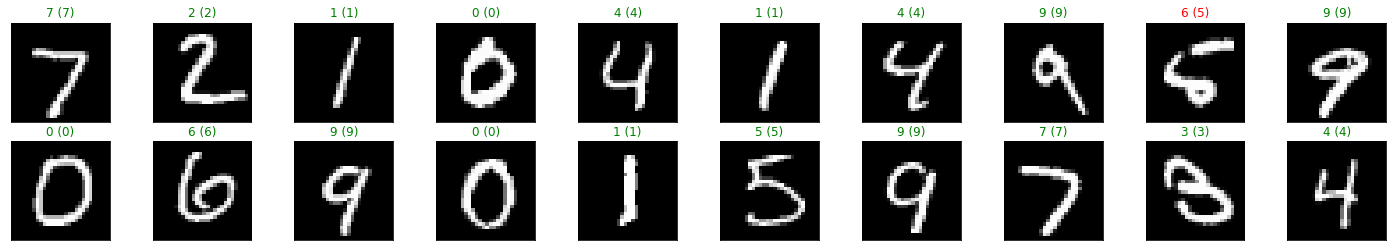

In [51]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))